# **Predicting the perception of deprivation from VHR Satelite Images.**

**In this part, we load, organize and transform all the input data to the format of input for deep learning model.**

# 1. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
import natsort
import sklearn
import datetime
import cv2
import shutil
import time
import h5py

from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Import custom functions

In [3]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

In [4]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir

# 2 Loading, structuring the data

In [5]:
# Define working path 
root = "/home/partimap/PARTIMAP_processing"
#image_path = os.path.join(root, "partimap_wv3_rgb")
image_path = os.path.join(root, "partimap_wv3_VNIR")
label_path = os.path.join(root, "partimap_ranking")
output_path = os.path.join(root, "output")
data_path = os.path.join(output_path, "data")
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results")

In [6]:
#Check and create output data directory if needed
list_directories = [output_path, model_path, results_path, data_path]
for path in list_directories:
    check_create_dir(path)  

The folder '/home/partimap/PARTIMAP_processing/output' already exists
The folder '/home/partimap/PARTIMAP_processing/output/model' already exists
The folder '/home/partimap/PARTIMAP_processing/output/results' already exists
The folder '/home/partimap/PARTIMAP_processing/output/data' already exists


**List of images tiles to be used**

In [7]:
# Create a list of all the filenames of images
tile_list = [x for x in os.listdir(image_path) if x.endswith(".tif")]
# Sort the list naturally based on the number in the filename.
tile_list = natsorted(tile_list)

In [8]:
# Remove unwanted images (images whith clouds that have been removed from the True-Skill ranking)
unwanted_ids = [96,97,99,100,101,108,109,370,371,378,386,387,389,396,397,408,417,418,421,422,430,431,444,445,446,447,456,459,460,461,462,466,467,468,469,470,473,474,475,476,479,483,484,488,493,502,503,504,510,520]
tile_list = [x for x in tile_list if int(os.path.splitext(x)[0].split("_")[-1]) not in unwanted_ids]

## 2.1 Y score (TrusSkill score)

In [9]:
# Load the labels stored in CSV into a pandas DataFrame
df_labels = pd.read_csv(os.path.join(label_path,"ranking_p3_20220202_NoClouds.csv"))
df_labels.head(15)

,photo_id,value
0,1,27.246599
1,2,25.581902
2,3,26.108904
3,4,26.940680
4,5,25.817791
5,6,25.316725
6,7,26.608992
7,8,28.059627
8,9,25.219071
9,10,22.994556


In [10]:
# Extract the values of perception score and covert it to a 1-d array 
scores = df_labels.loc[:,'value'].values
photo_id = df_labels.loc[:,'photo_id'].values

In [11]:
# Now we need to reshape the 1-d array to a 2-d array 
scores = scores.reshape(scores.size,-1)
photo_id = photo_id.reshape(photo_id.size,-1)

# Check the shape and datatype of reference data
print(scores.shape)
print(scores.dtype)
print(scores)

(1998, 1)
float64
[[27.24659875]
 [25.58190216]
 [26.10890421]
 ...
 [25.14122653]
 [27.26761963]
 [26.21339917]]


## 2.1 Images VNIR (4bands) Shape 1284x128x3

In [24]:
# Loop over and read all the images as numpy array, then stack them together 
rawimgsize = 333 #raw data size (333x333 pixel)
resizesize = 128 #resampling size
stack = []
for tile in tile_list: 
    ds = gdal.Open(image_path + os.path.sep + tile)
    data = gdal_array.DatasetReadAsArray(ds, win_xsize=rawimgsize, win_ysize=rawimgsize, buf_xsize=resizesize, buf_ysize=resizesize) #resize (resample) raw data 
    data = np.transpose(data,(1,2,0)) #swap the axises to make the number of bands as the final dimension. 
    stack.append(data.astype(np.float16))

# Now, change the list into numpy array 
stack = np.array(stack)
print(stack.shape)

(1998, 128, 128, 4)


In [25]:
# check the datatype of the loaded numpy arrray
print(stack.dtype)

float16


In [26]:
stack[0,:,:,0]

array([[187., 201., 198., ..., 283., 280., 233.],
       [164., 165., 160., ..., 332., 159., 103.],
       [157., 152., 157., ...,  94.,  93., 104.],
       ...,
       [295., 295., 299., ..., 122.,  70.,  56.],
       [117., 114., 139., ..., 115.,  73.,  65.],
       [ 14.,  20.,  21., ..., 140.,  90.,  81.]], dtype=float16)

In [27]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

def standardise_channel(image_data):
    for ch_idx in range(image_data.shape[-1])[:1]:
        mean = image_data[:,:,:,ch_idx].mean()
        std = image_data[:,:,:,ch_idx].std()
        image_data[:,:,:,ch_idx] -= mean
        image_data[:,:,:,ch_idx] /= std
    return image_data
    
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0, dtype=np.float32)
    image_data /= (np.max(stack, axis=0, dtype=np.float32) - np.min(stack, axis=0, dtype=np.float32))
    return image_data

#stack = standardise_channel(stack)
stack = standardise(stack)
#stack = normalise_01(stack)
print(stack.shape)
print(stack.dtype)

(1998, 128, 128, 4)
float16


In [28]:
stack[0,:,:,0]

array([[ 0.2023 ,  0.331  ,  0.3157 , ...,  1.098  ,  1.155  ,  0.6978 ],
       [-0.0177 , -0.0062 , -0.04617, ...,  1.586  , -0.0735 , -0.646  ],
       [-0.09985, -0.1371 , -0.102  , ..., -0.7026 , -0.738  , -0.639  ],
       ...,
       [ 1.264  ,  1.166  ,  1.246  , ..., -0.4282 , -0.983  , -1.106  ],
       [-0.4841 , -0.535  , -0.2979 , ..., -0.495  , -0.9214 , -0.95   ],
       [-1.451  , -1.432  , -1.453  , ..., -0.2625 , -0.721  , -0.8125 ]],
      dtype=float16)

In [29]:
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
    a = np.ndarray(image_data.shape, dtype='float32')  
    a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
    a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
    a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
    if BGR2RGB: 
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


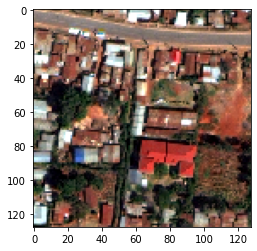

In [30]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

In [31]:
# Before splitting the training and test dataset, let's check again the shape of x and y. 
print(stack.shape)
print(scores.shape)

(1998, 128, 128, 4)
(1998, 1)


In [32]:
# Check if labels and images ID match
set_images = set([int(os.path.splitext(x)[0].split("_")[-1]) for x in tile_list])
set_label = set(df_labels.loc[:,'photo_id'].values.tolist())
missing_label = list(sorted(set_images - set_label))
missing_image = list(sorted(set_label - set_images))
if missing_label or missing_image: 
    print('Label(s) ID missing:', missing_label)
    print('Image(s) ID missing:', missing_image)
else: 
    print('Labels and images ID match perfectly') 

Labels and images ID match perfectly


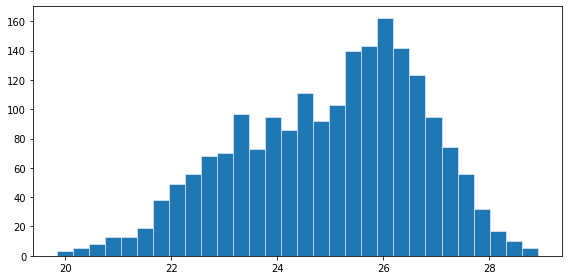

In [33]:
# print the distribution of target variables (y)
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(scores, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 2.1.2 Splitting the input data

**Now, we split the input data into training+validation and test datasets.**

We use a random selection made on the grid shapefile using the "random selection" algorithm in QGIS. 

In [34]:
# Get Grid ID to be used for training and test grids
train_ID = pd.read_csv(os.path.join(root,'grids','train_test','Partimap_Train_split.csv'))['PARTIMAP_I'].tolist() # Training split
test_ID = pd.read_csv(os.path.join(root,'grids','train_test','Partimap_Test_split.csv'))['PARTIMAP_I'].tolist() # Test split
# Get idex from original dataset 
idx_train = [i for i,x in enumerate(photo_id) if x in train_ID]
idx_test = [i for i,x in enumerate(photo_id) if x in test_ID]
# Select train and test split from the original dataset 
x_test = stack[idx_test]
y_test = scores[idx_test]
x_train = stack[idx_train]
y_train = scores[idx_train]

Display random selection from the trainig and test split with corresponding PARTIMAP_ID and TrueSkill-score for manual check in QGIS. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


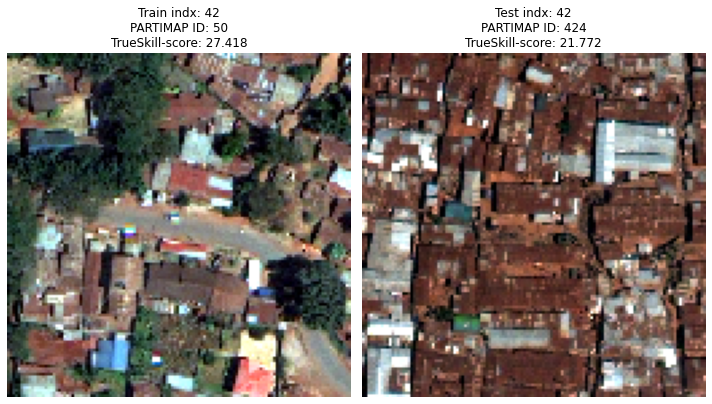

In [35]:
rd = np.random.randint(50)
# Random selection in the training set and test set
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(10, 10))
for i in range(2):
    if i==0:
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(Norma_Xpercentile(x_train[rd,:,:,]))
        plt.axis("off")
        plt.title("Train indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd,train_ID[rd],y_train[rd]))
    else:
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(Norma_Xpercentile(x_test[rd,:,:,]))
        plt.axis("off")
        plt.title("Test indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd,test_ID[rd],y_test[rd]))
        
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 

In [36]:
# Check the shape of each sub-dataset 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1799, 128, 128, 4)
(1799, 1)
(199, 128, 128, 4)
(199, 1)


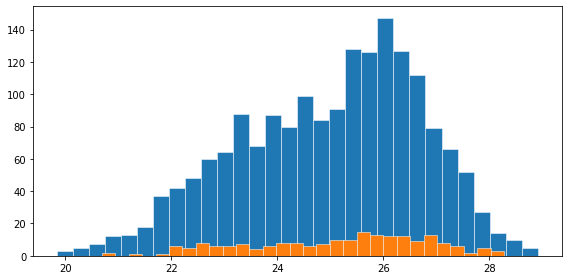

In [37]:
# print the distribution of target variables (y) in training and validation sets
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(y_train, bins = 30, edgecolor='white', linewidth=0.5)
axs.hist(y_test, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 2.1.3 Save the datasets

In [38]:
with h5py.File(os.path.join(data_path,"VNIR_128.hdf5"), mode="w") as f:
    f["x_train"] = x_train
    f["x_test"] = x_test
    f["y_train"] = y_train
    f["y_test"] = y_test
    f["train_ID"] = train_ID
    f["test_ID"] = test_ID

## 2.2 Images RGB (3 bands) Shape 1284x128x3

In [39]:
# Loop over and read all the images as numpy array, then stack them together 
rawimgsize = 333 #raw data size (333x333 pixel)
resizesize = 128 #resampling size
stack = []
for tile in tile_list: 
    ds = gdal.Open(image_path + os.path.sep + tile)
    data = gdal_array.DatasetReadAsArray(ds, win_xsize=rawimgsize, win_ysize=rawimgsize, buf_xsize=resizesize, buf_ysize=resizesize) #resize (resample) raw data 
    data = np.transpose(data,(1,2,0)) #swap the axises to make the number of bands as the final dimension. 
    data = np.delete(data,3,2) #Remove the NIR channel in the array (4rd element of the 3rd dimension (index start at 0)
    stack.append(data.astype(np.float16))

# Now, change the list into numpy array 
stack = np.array(stack)
print(stack.shape)

(1998, 128, 128, 3)


In [40]:
# check the datatype of the loaded numpy arrray
print(stack.dtype)

float16


In [41]:
stack[0,:,:,0]

array([[187., 201., 198., ..., 283., 280., 233.],
       [164., 165., 160., ..., 332., 159., 103.],
       [157., 152., 157., ...,  94.,  93., 104.],
       ...,
       [295., 295., 299., ..., 122.,  70.,  56.],
       [117., 114., 139., ..., 115.,  73.,  65.],
       [ 14.,  20.,  21., ..., 140.,  90.,  81.]], dtype=float16)

In [42]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

def standardise_channel(image_data):
    for ch_idx in range(image_data.shape[-1])[:1]:
        mean = image_data[:,:,:,ch_idx].mean()
        std = image_data[:,:,:,ch_idx].std()
        image_data[:,:,:,ch_idx] -= mean
        image_data[:,:,:,ch_idx] /= std
    return image_data
    
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0, dtype=np.float32)
    image_data /= (np.max(stack, axis=0, dtype=np.float32) - np.min(stack, axis=0, dtype=np.float32))
    return image_data

#stack = standardise_channel(stack)
stack = standardise(stack)
#stack = normalise_01(stack)
print(stack.shape)
print(stack.dtype)

(1998, 128, 128, 3)
float16


In [43]:
stack[0,:,:,0]

array([[ 0.2023 ,  0.331  ,  0.3157 , ...,  1.098  ,  1.155  ,  0.6978 ],
       [-0.0177 , -0.0062 , -0.04617, ...,  1.586  , -0.0735 , -0.646  ],
       [-0.09985, -0.1371 , -0.102  , ..., -0.7026 , -0.738  , -0.639  ],
       ...,
       [ 1.264  ,  1.166  ,  1.246  , ..., -0.4282 , -0.983  , -1.106  ],
       [-0.4841 , -0.535  , -0.2979 , ..., -0.495  , -0.9214 , -0.95   ],
       [-1.451  , -1.432  , -1.453  , ..., -0.2625 , -0.721  , -0.8125 ]],
      dtype=float16)

In [44]:
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
    a = np.ndarray(image_data.shape, dtype='float32')  
    a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
    a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
    a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
    if BGR2RGB: 
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


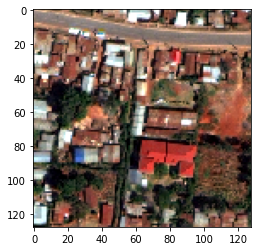

In [45]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

In [46]:
# Before splitting the training and test dataset, let's check again the shape of x and y. 
print(stack.shape)
print(scores.shape)

(1998, 128, 128, 3)
(1998, 1)


In [47]:
# Check if labels and images ID match
set_images = set([int(os.path.splitext(x)[0].split("_")[-1]) for x in tile_list])
set_label = set(df_labels.loc[:,'photo_id'].values.tolist())
missing_label = list(sorted(set_images - set_label))
missing_image = list(sorted(set_label - set_images))
if missing_label or missing_image: 
    print('Label(s) ID missing:', missing_label)
    print('Image(s) ID missing:', missing_image)
else: 
    print('Labels and images ID match perfectly') 

Labels and images ID match perfectly


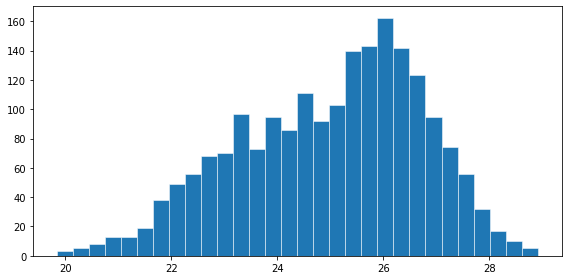

In [48]:
# print the distribution of target variables (y)
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(scores, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 2.2.2 Splitting the input data

**Now, we split the input data into training+validation and test datasets.**

We use a random selection made on the grid shapefile using the "random selection" algorithm in QGIS. 

In [49]:
# Get Grid ID to be used for training and test grids
train_ID = pd.read_csv(os.path.join(root,'grids','train_test','Partimap_Train_split.csv'))['PARTIMAP_I'].tolist() # Training split
test_ID = pd.read_csv(os.path.join(root,'grids','train_test','Partimap_Test_split.csv'))['PARTIMAP_I'].tolist() # Test split
# Get idex from original dataset 
idx_train = [i for i,x in enumerate(photo_id) if x in train_ID]
idx_test = [i for i,x in enumerate(photo_id) if x in test_ID]
# Select train and test split from the original dataset 
x_test = stack[idx_test]
y_test = scores[idx_test]
x_train = stack[idx_train]
y_train = scores[idx_train]

Display random selection from the trainig and test split with corresponding PARTIMAP_ID and TrueSkill-score for manual check in QGIS. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


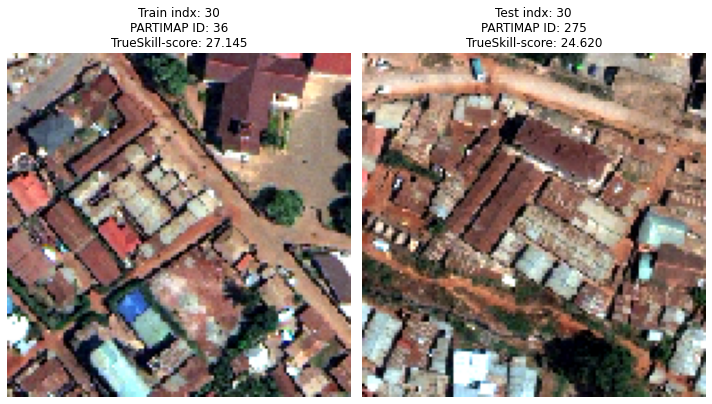

In [50]:
rd = np.random.randint(50)
# Random selection in the training set and test set
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(10, 10))
for i in range(2):
    if i==0:
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(Norma_Xpercentile(x_train[rd,:,:,]))
        plt.axis("off")
        plt.title("Train indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd,train_ID[rd],y_train[rd]))
    else:
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(Norma_Xpercentile(x_test[rd,:,:,]))
        plt.axis("off")
        plt.title("Test indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd,test_ID[rd],y_test[rd]))
        
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 

In [51]:
# Check the shape of each sub-dataset 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1799, 128, 128, 3)
(1799, 1)
(199, 128, 128, 3)
(199, 1)


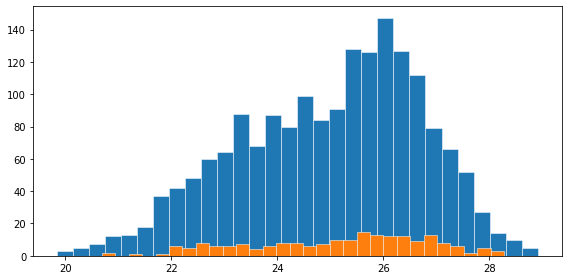

In [52]:
# print the distribution of target variables (y) in training and validation sets
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(y_train, bins = 30, edgecolor='white', linewidth=0.5)
axs.hist(y_test, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 2.2.3 Save the datasets

In [53]:
with h5py.File(os.path.join(data_path,"RGB_128.hdf5"), mode="w") as f:
    f["x_train"] = x_train
    f["x_test"] = x_test
    f["y_train"] = y_train
    f["y_test"] = y_test
    f["train_ID"] = train_ID
    f["test_ID"] = test_ID

## 2.3 Images R-G-NIR (3 bands) Shape 128x128x3

In [54]:
# Loop over and read all the images as numpy array, then stack them together 
rawimgsize = 333 #raw data size (333x333 pixel)
resizesize = 128 #resampling size
stack = []
for tile in tile_list: 
    ds = gdal.Open(image_path + os.path.sep + tile)
    data = gdal_array.DatasetReadAsArray(ds, win_xsize=rawimgsize, win_ysize=rawimgsize, buf_xsize=resizesize, buf_ysize=resizesize) #resize (resample) raw data 
    data = np.transpose(data,(1,2,0)) #swap the axises to make the number of bands as the final dimension. 
    data = np.delete(data,2,2) #Remove the B channel in the array (3rd element of the 3rd dimension (index start at 0)
    stack.append(data.astype(np.float16))

# Now, change the list into numpy array 
stack = np.array(stack)
print(stack.shape)

(1998, 128, 128, 3)


In [55]:
# check the datatype of the loaded numpy arrray
print(stack.dtype)

float16


In [56]:
stack[0,:,:,0]

array([[187., 201., 198., ..., 283., 280., 233.],
       [164., 165., 160., ..., 332., 159., 103.],
       [157., 152., 157., ...,  94.,  93., 104.],
       ...,
       [295., 295., 299., ..., 122.,  70.,  56.],
       [117., 114., 139., ..., 115.,  73.,  65.],
       [ 14.,  20.,  21., ..., 140.,  90.,  81.]], dtype=float16)

In [57]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

def standardise_channel(image_data):
    for ch_idx in range(image_data.shape[-1])[:1]:
        mean = image_data[:,:,:,ch_idx].mean()
        std = image_data[:,:,:,ch_idx].std()
        image_data[:,:,:,ch_idx] -= mean
        image_data[:,:,:,ch_idx] /= std
    return image_data
    
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0, dtype=np.float32)
    image_data /= (np.max(stack, axis=0, dtype=np.float32) - np.min(stack, axis=0, dtype=np.float32))
    return image_data

#stack = standardise_channel(stack)
stack = standardise(stack)
#stack = normalise_01(stack)
print(stack.shape)
print(stack.dtype)

(1998, 128, 128, 3)
float16


In [58]:
stack[0,:,:,0]

array([[ 0.2023 ,  0.331  ,  0.3157 , ...,  1.098  ,  1.155  ,  0.6978 ],
       [-0.0177 , -0.0062 , -0.04617, ...,  1.586  , -0.0735 , -0.646  ],
       [-0.09985, -0.1371 , -0.102  , ..., -0.7026 , -0.738  , -0.639  ],
       ...,
       [ 1.264  ,  1.166  ,  1.246  , ..., -0.4282 , -0.983  , -1.106  ],
       [-0.4841 , -0.535  , -0.2979 , ..., -0.495  , -0.9214 , -0.95   ],
       [-1.451  , -1.432  , -1.453  , ..., -0.2625 , -0.721  , -0.8125 ]],
      dtype=float16)

In [59]:
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
    a = np.ndarray(image_data.shape, dtype='float32')  
    a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
    a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
    a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
    if BGR2RGB: 
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


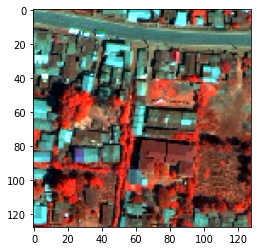

In [60]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

In [61]:
# Before splitting the training and test dataset, let's check again the shape of x and y. 
print(stack.shape)
print(scores.shape)

(1998, 128, 128, 3)
(1998, 1)


In [62]:
# Check if labels and images ID match
set_images = set([int(os.path.splitext(x)[0].split("_")[-1]) for x in tile_list])
set_label = set(df_labels.loc[:,'photo_id'].values.tolist())
missing_label = list(sorted(set_images - set_label))
missing_image = list(sorted(set_label - set_images))
if missing_label or missing_image: 
    print('Label(s) ID missing:', missing_label)
    print('Image(s) ID missing:', missing_image)
else: 
    print('Labels and images ID match perfectly') 

Labels and images ID match perfectly


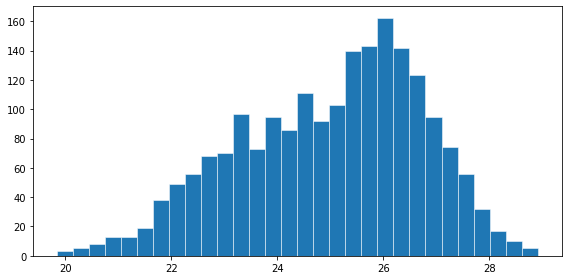

In [63]:
# print the distribution of target variables (y)
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(scores, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 2.2.2 Splitting the input data

**Now, we split the input data into training+validation and test datasets.**

We use a random selection made on the grid shapefile using the "random selection" algorithm in QGIS. 

In [64]:
# Get Grid ID to be used for training and test grids
train_ID = pd.read_csv(os.path.join(root,'grids','train_test','Partimap_Train_split.csv'))['PARTIMAP_I'].tolist() # Training split
test_ID = pd.read_csv(os.path.join(root,'grids','train_test','Partimap_Test_split.csv'))['PARTIMAP_I'].tolist() # Test split
# Get idex from original dataset 
idx_train = [i for i,x in enumerate(photo_id) if x in train_ID]
idx_test = [i for i,x in enumerate(photo_id) if x in test_ID]
# Select train and test split from the original dataset 
x_test = stack[idx_test]
y_test = scores[idx_test]
x_train = stack[idx_train]
y_train = scores[idx_train]

Display random selection from the trainig and test split with corresponding PARTIMAP_ID and TrueSkill-score for manual check in QGIS. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


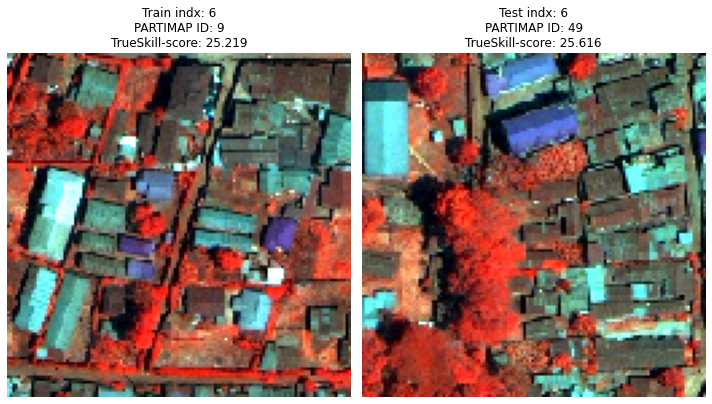

In [65]:
rd = np.random.randint(50)
# Random selection in the training set and test set
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(10, 10))
for i in range(2):
    if i==0:
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(Norma_Xpercentile(x_train[rd,:,:,]))
        plt.axis("off")
        plt.title("Train indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd,train_ID[rd],y_train[rd]))
    else:
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(Norma_Xpercentile(x_test[rd,:,:,]))
        plt.axis("off")
        plt.title("Test indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd,test_ID[rd],y_test[rd]))
        
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 

In [66]:
# Check the shape of each sub-dataset 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1799, 128, 128, 3)
(1799, 1)
(199, 128, 128, 3)
(199, 1)


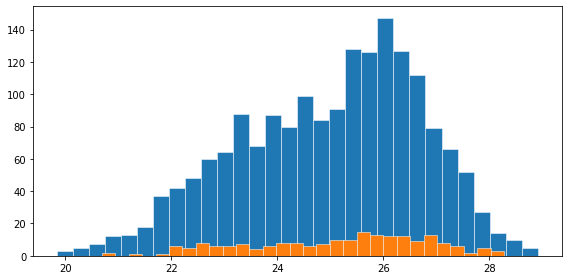

In [67]:
# print the distribution of target variables (y) in training and validation sets
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(y_train, bins = 30, edgecolor='white', linewidth=0.5)
axs.hist(y_test, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 2.2.3 Save the datasets

In [68]:
with h5py.File(os.path.join(data_path,"RGNIR_128.hdf5"), mode="w") as f:
    f["x_train"] = x_train
    f["x_test"] = x_test
    f["y_train"] = y_train
    f["y_test"] = y_test
    f["train_ID"] = train_ID
    f["test_ID"] = test_ID

## 2.4 Images R-G-NIR (3 bands) Shape 224x224x3

In [12]:
# Loop over and read all the images as numpy array, then stack them together 
rawimgsize = 333 #raw data size (333x333 pixel)
resizesize = 224 #resampling size
stack = []
for tile in tile_list: 
    ds = gdal.Open(image_path + os.path.sep + tile)
    data = gdal_array.DatasetReadAsArray(ds, win_xsize=rawimgsize, win_ysize=rawimgsize, buf_xsize=resizesize, buf_ysize=resizesize) #resize (resample) raw data 
    data = np.transpose(data,(1,2,0)) #swap the axises to make the number of bands as the final dimension. 
    data = np.delete(data,2,2) #Remove the B channel in the array (3rd element of the 3rd dimension (index start at 0)
    stack.append(data.astype(np.float16))

# Now, change the list into numpy array 
stack = np.array(stack)
print(stack.shape)

(1998, 224, 224, 3)


In [13]:
# check the datatype of the loaded numpy arrray
print(stack.dtype)

float16


In [14]:
stack[0,:,:,0]

array([[187., 201., 207., ..., 304., 280., 233.],
       [164., 165., 163., ..., 303., 159., 103.],
       [159., 159., 155., ..., 234., 141.,  92.],
       ...,
       [198., 204., 201., ..., 130.,  80.,  83.],
       [117., 114., 124., ..., 124.,  73.,  65.],
       [ 14.,  20.,  24., ...,  98.,  90.,  81.]], dtype=float16)

In [15]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

def standardise_channel(image_data):
    for ch_idx in range(image_data.shape[-1])[:1]:
        mean = image_data[:,:,:,ch_idx].mean()
        std = image_data[:,:,:,ch_idx].std()
        image_data[:,:,:,ch_idx] -= mean
        image_data[:,:,:,ch_idx] /= std
    return image_data
    
def normalise_01(image_data):
    image_data -= np.min(stack, axis=0, dtype=np.float32)
    image_data /= (np.max(stack, axis=0, dtype=np.float32) - np.min(stack, axis=0, dtype=np.float32))
    return image_data

#stack = standardise_channel(stack)
stack = standardise(stack)
#stack = normalise_01(stack)
print(stack.shape)
print(stack.dtype)

(1998, 224, 224, 3)
float16


In [16]:
stack[0,:,:,0]

array([[ 0.2023 ,  0.331  ,  0.4043 , ...,  1.39   ,  1.184  ,  0.7026 ],
       [-0.0177 , -0.0062 , -0.03003, ...,  1.374  , -0.07745, -0.6455 ],
       [-0.07495, -0.075  , -0.1147 , ...,  0.6704 , -0.2615 , -0.7505 ],
       ...,
       [ 0.2803 ,  0.3237 ,  0.2917 , ..., -0.3816 , -0.8276 , -0.799  ],
       [-0.479  , -0.536  , -0.4353 , ..., -0.4326 , -0.881  , -0.947  ],
       [-1.421  , -1.418  , -1.399  , ..., -0.6523 , -0.7456 , -0.8115 ]],
      dtype=float16)

In [17]:
def Norma_Xpercentile(image_data, prct:int = 2, BGR2RGB=True):
    a = np.ndarray(image_data.shape, dtype='float32')  
    a[:,:,0] = (image_data[:,:,0] - np.nanpercentile(image_data[:,:,0],prct))/(np.nanpercentile(image_data[:,:,0],100-prct) - np.nanpercentile(image_data[:,:,0],prct))
    a[:,:,1] = (image_data[:,:,1] - np.nanpercentile(image_data[:,:,1],prct))/(np.nanpercentile(image_data[:,:,1],100-prct) - np.nanpercentile(image_data[:,:,1],prct))
    a[:,:,2] = (image_data[:,:,2] - np.nanpercentile(image_data[:,:,2],prct))/(np.nanpercentile(image_data[:,:,2],100-prct) - np.nanpercentile(image_data[:,:,2],prct))
    if BGR2RGB: 
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


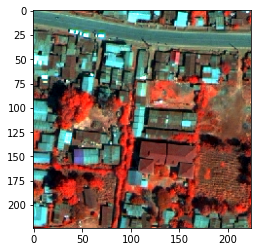

In [18]:
plt.imshow(Norma_Xpercentile(stack[0,:,:,]))

In [19]:
# Before splitting the training and test dataset, let's check again the shape of x and y. 
print(stack.shape)
print(scores.shape)

(1998, 224, 224, 3)
(1998, 1)


In [20]:
# Check if labels and images ID match
set_images = set([int(os.path.splitext(x)[0].split("_")[-1]) for x in tile_list])
set_label = set(df_labels.loc[:,'photo_id'].values.tolist())
missing_label = list(sorted(set_images - set_label))
missing_image = list(sorted(set_label - set_images))
if missing_label or missing_image: 
    print('Label(s) ID missing:', missing_label)
    print('Image(s) ID missing:', missing_image)
else: 
    print('Labels and images ID match perfectly') 

Labels and images ID match perfectly


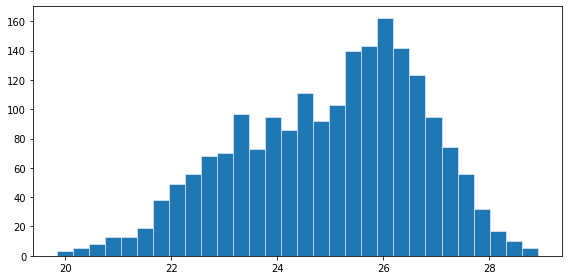

In [21]:
# print the distribution of target variables (y)
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(scores, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 2.2.2 Splitting the input data

**Now, we split the input data into training+validation and test datasets.**

We use a random selection made on the grid shapefile using the "random selection" algorithm in QGIS. 

In [22]:
# Get Grid ID to be used for training and test grids
train_ID = pd.read_csv(os.path.join(root,'grids','train_test','Partimap_Train_split.csv'))['PARTIMAP_I'].tolist() # Training split
test_ID = pd.read_csv(os.path.join(root,'grids','train_test','Partimap_Test_split.csv'))['PARTIMAP_I'].tolist() # Test split
# Get idex from original dataset 
idx_train = [i for i,x in enumerate(photo_id) if x in train_ID]
idx_test = [i for i,x in enumerate(photo_id) if x in test_ID]
# Select train and test split from the original dataset 
x_test = stack[idx_test]
y_test = scores[idx_test]
x_train = stack[idx_train]
y_train = scores[idx_train]

Display random selection from the trainig and test split with corresponding PARTIMAP_ID and TrueSkill-score for manual check in QGIS. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


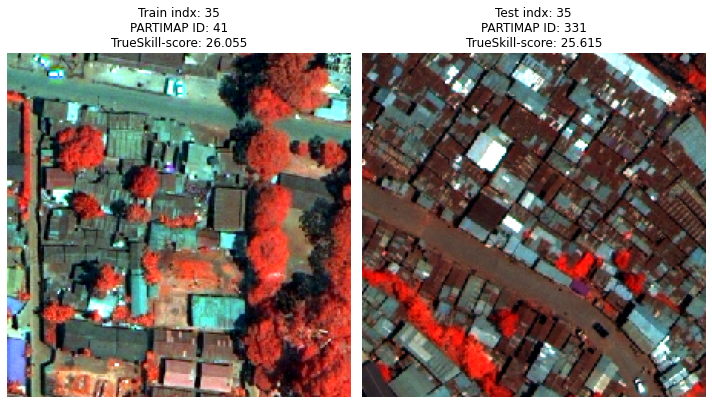

In [25]:
rd = np.random.randint(50)
# Random selection in the training set and test set
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(10, 10))
for i in range(2):
    if i==0:
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(Norma_Xpercentile(x_train[rd,:,:,]))
        plt.axis("off")
        plt.title("Train indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd,train_ID[rd],y_train[rd]))
    else:
        ax = plt.subplot(1, 2, i + 1)
        plt.imshow(Norma_Xpercentile(x_test[rd,:,:,]))
        plt.axis("off")
        plt.title("Test indx: %s\nPARTIMAP ID: %s\nTrueSkill-score: %0.3f" %(rd,test_ID[rd],y_test[rd]))
        
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 

In [26]:
# Check the shape of each sub-dataset 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1799, 224, 224, 3)
(1799, 1)
(199, 224, 224, 3)
(199, 1)


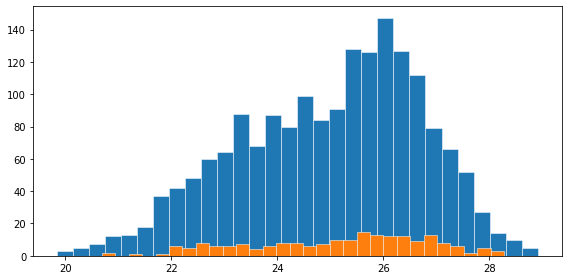

In [27]:
# print the distribution of target variables (y) in training and validation sets
fig, axs = plt.subplots(1, 1,figsize =(8, 4), tight_layout = True)
axs.hist(y_train, bins = 30, edgecolor='white', linewidth=0.5)
axs.hist(y_test, bins = 30, edgecolor='white', linewidth=0.5)
# Show plot
plt.show()

### 2.2.3 Save the datasets

In [23]:
with h5py.File(os.path.join(data_path,"RGNIR_224.hdf5"), mode="w") as f:
    f["x_train"] = x_train
    f["x_test"] = x_test
    f["y_train"] = y_train
    f["y_test"] = y_test
    f["train_ID"] = train_ID
    f["test_ID"] = test_ID